# Sprint 深層学習スクラッチ ディープニューラルネットワーク

### データセット

In [55]:
import numpy as np
from sklearn import metrics
from keras.datasets import mnist
import matplotlib.pyplot as plt
%matplotlib inline
(X_train, y_train), (X_test, y_test) = mnist.load_data()

### 平滑化

In [37]:
X_train = X_train.reshape(-1 ,784)
X_test = X_test.reshape(-1, 784)

### 前処理

In [38]:
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255
# print(X_train.max()) # 1.0
# print(X_train.min()) # 0.0

### one-hot表現への変換

In [39]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
# print(y_train.shape) #(60000, 10)
# print(y_train_one_hot.shape) #(60000, 10)
# print(y_train_one_hot.dtype) # float64

### 訓練データ6万枚の内2割を検証データとして分割

In [40]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)
# print(X_train.shape) # (48000, 784)
# print(X_val.shape) # (12000, 784)

### ミニバッチ処理《コード》

In [41]:
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      訓練データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
    def __len__(self):
        return self._stop
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]        
    def __iter__(self):
        self._counter = 0
        return self
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

In [42]:
get_mini_batch = GetMiniBatch(X_train, y_train, batch_size=20)
# print(len(get_mini_batch)) # 2400
# print(get_mini_batch[5]) # 5番目のミニバッチが取得できる
for mini_X_train, mini_y_train in get_mini_batch:
    # このfor文内でミニバッチが使える
    pass

## 【問題1】全結合層のクラス化

全結合層のクラス化を行なってください。


以下に雛形を載せました。コンストラクタで重みやバイアスの初期化をして、あとはフォワードとバックワードのメソッドを用意します。重みW、バイアスB、およびフォワード時の入力Xをインスタンス変数として保持しておくことで、煩雑な入出力は不要になります。


なお、インスタンスも引数として渡すことができます。そのため、初期化方法のインスタンスinitializerをコンストラクタで受け取れば、それにより初期化が行われます。渡すインスタンスを変えれば、初期化方法が変えられます。


また、引数として自身のインスタンスselfを渡すこともできます。これを利用してself.optimizer.update(self)という風に層の重みの更新が可能です。更新に必要な値は複数ありますが、全て全結合層が持つインスタンス変数にすることができます。


初期化方法と最適化手法のクラスについては後述します。



In [43]:
class FC:
    """
    ノード数n_nodes1からn_nodes2への全結合層
    Parameters
    ----------
    n_nodes1 : int
      前の層のノード数
    n_nodes2 : int
      後の層のノード数
    initializer : 初期化方法のインスタンス
    optimizer : 最適化手法のインスタンス
    """
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer):
        self.optimizer = optimizer
        # 初期化
        # initializerのメソッドを使い、self.Wとself.Bを初期化する
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2
        self.W = initializer.W(n_nodes1, n_nodes2)
        self.B = initializer.B(n_nodes2)
        self.WH = 0
        self.BH = 0
        
    def forward(self, X):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, n_nodes1)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes2)
            出力
        """ 
        self.X = X
        A = self.X@self.W + self.B
        return A
    
    def backward(self, dA):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (batch_size, n_nodes2)
            後ろから流れてきた勾配
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """
        self.dA = dA
        self.dW = np.mean(self.X, axis=0).T.reshape(-1, 1) @ self.dA
        self.dB = self.dA
    
        dZ = self.dA @ self.W.T 
        self = self.optimizer.update(self) 
        
        return dZ

## 【問題2】初期化方法のクラス化
初期化を行うコードをクラス化してください。


前述のように、全結合層のコンストラクタに初期化方法のインスタンスを渡せるようにします。以下の雛形に必要なコードを書き加えていってください。標準偏差の値（sigma）はコンストラクタで受け取るようにすることで、全結合層のクラス内にこの値（sigma）を渡さなくてすむようになります。


これまで扱ってきた初期化方法はSimpleInitializerクラスと名付けることにします。

In [44]:
class SimpleInitializer:
    """
    ガウス分布によるシンプルな初期化
    Parameters
    ----------
    sigma : float
      ガウス分布の標準偏差
    """
    def __init__(self, sigma):
        self.sigma = sigma
        
    def W(self, n_nodes1, n_nodes2):
        """
        重みの初期化
        Parameters
        ----------
        n_nodes1 : int
          前の層のノード数
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        W :
        """
        W = self.sigma * np.random.randn(n_nodes1, n_nodes2)
        return W
    
    def B(self, n_nodes2):
        """
        バイアスの初期化
        Parameters
        ----------
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        B :
        """
        B = np.random.randn(n_nodes2)
        return B

## 【問題3】最適化手法のクラス化
最適化手法のクラス化を行なってください。


最適化手法に関しても初期化方法同様に全結合層にインスタンスとして渡します。バックワードのときにself.optimizer.update(self)のように更新できるようにします。以下の雛形に必要なコードを書き加えていってください。


これまで扱ってきた最適化手法はSGDクラス（Stochastic Gradient Descent、確率的勾配降下法）として作成します。

In [45]:
class SGD:
    """
    確率的勾配降下法
    Parameters
    ----------
    lr : 学習率
    """
    def __init__(self, lr):
        self.lr = lr
    def update(self, layer):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : 更新前の層のインスタンス
        """
        layer.W = layer.W - self.lr*layer.dW
        layer.B = layer.B - self.lr*layer.dB
        
        return layer

## 【問題4】活性化関数のクラス化
活性化関数のクラス化を行なってください。


ソフトマックス関数のバックプロパゲーションには交差エントロピー誤差の計算も含む実装を行うことで計算が簡略化されます。

In [46]:
class Tanh():
    def forward(self, A):
        self.A = A
        Z = np.tanh(self.A)
        return Z
    
    def backward(self, dZ):
        dA = dZ * (1 - np.tanh(np.mean(self.A, axis=0))**2)
        return dA

In [47]:
class Softmax():
    def forward(self, A):
        Z = np.exp(A) / np.sum(np.exp(A), axis=1).reshape(-1, 1)
        return Z
    
    def backward(self, Z, Y):
        dA = np.mean(Z - Y, axis=0).reshape(1, -1) #shape(1, 10)
        self.loss = -1 * np.mean(np.sum(Y * np.log(Z), axis=1))
        return dA

## 【問題5】ReLUクラスの作成

現在一般的に使われている活性化関数であるReLU（Rectified Linear Unit）をReLUクラスとして実装してください。
$
f(x) = ReLU(x) = \begin{cases}
x  & \text{if $x>0$,}\\
0 & \text{if $x\leqq0$.}
\end{cases}
$

x
 : ある特徴量。スカラー

In [48]:
class ReLU():
    def forward(self, X):
        self.X = X
        Z = np.where(self.X>0, self.X, 0)
        return Z
    
    def backward(self, dZ):
        dA = dZ * np.where(self.X>0, 1, 0)
        return dA

## 【問題6】重みの初期値
ここまでは重みやバイアスの初期値は単純にガウス分布で、標準偏差をハイパーパラメータとして扱ってきました。しかし、どのような値にすると良いかが知られています。シグモイド関数やハイパボリックタンジェント関数のときは Xavierの初期値 （またはGlorotの初期値）、ReLUのときは Heの初期値 が使われます。


XavierInitializerクラスと、HeInitializerクラスを作成してください。

### Xavierの初期値

In [49]:
class XavierInitializer():
    def W(self, n_nodes1, n_nodes2):
        self.sigma = 1 / np.sqrt(n_nodes1)
        W = self.sigma * np.random.randn(n_nodes1, n_nodes2)
        return W
    
    def B(self, n_nodes2):
        B = self.sigma * np.random.randn(n_nodes2)
        return B

### Heの初期値

In [50]:
class HeInitializer():
    def W(self, n_nodes1, n_nodes2):
        self.sigma = np.sqrt(2/n_nodes1)
        W = self.sigma * np.random.randn(n_nodes1, n_nodes2)
        return W
    
    def B(self, n_nodes2):
        B = self.sigma * np.random.randn(n_nodes2)
        return B

## 【問題7】最適化手法
学習率は学習過程で変化させていく方法が一般的です。基本的な手法である AdaGrad のクラスを作成してください。

In [51]:
class AdaGrad():
    def __init__(self):
        self.lr = 0.01
        self.WH = np.zeros(1)
        self.BH = np.zeros(1)
        pass
    def update(self, layer):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : 更新前の層のインスタンス
        """
        layer.WH = layer.WH + layer.dW * layer.dW
        layer.BH = layer.BH + layer.dB * layer.dB
        layer.W = layer.W - self.lr*np.sqrt(layer.WH) * layer.dW
        layer.B = layer.B - self.lr*np.sqrt(layer.BH) * layer.dB
        
        return layer

## 【問題8】クラスの完成
任意の構成で学習と推定が行えるScratchDeepNeuralNetrowkClassifierクラスを完成させてください。


In [33]:
class ScratchDeepNeuralNetrowkClassifier():
    """
    シンプルな三層ニューラルネットワーク分類器

    Parameters
    ----------

    Attributes
    ----------
    """
    def __init__(self, epoch=2, lr=0.01, verbose=True):
        self.verbose = verbose
        self.lr = lr
        self.epoch = epoch
        self.mini_y_train = None
        self.train_loss_list = []

    def fit(self, X, y, X_val=None, y_val=None):
        """
        ニューラルネットワーク分類器を学習する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練用データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            訓練用データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)
            検証用データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証用データの正解値
        """
        enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
        y_train_one_hot = enc.fit_transform(y[:, np.newaxis])
        
        self.n_features = X.shape[1]
        self.n_nodes1 = 400
        self.n_nodes2 = 200
        self.sigma = 0.01 
        batch_size = 20
        self.n_output = 10
        
        optimizer = SGD(self.lr)
        
        get_mini_batch = GetMiniBatch(X, y_train_one_hot, batch_size=20)
        if self.verbose:
            print("train data learning process\n")
            
        self.FC1 = FC(self.n_features, self.n_nodes1, XavierInitializer(), optimizer)
        self.FC2 = FC(self.n_nodes1, self.n_nodes2, XavierInitializer(), optimizer)
        self.FC3 = FC(self.n_nodes2, self.n_output, XavierInitializer(), optimizer)
        
        for _ in range(self.epoch):
            for mini_X_train, mini_y_train in get_mini_batch:
                self.mini_y_train = mini_y_train
                
                self.activation1 = Tanh()
                A1 = self.FC1.forward(mini_X_train)
                Z1 = self.activation1.forward(A1)
                
                self.activation2 = Tanh()
                A2 = self.FC2.forward(Z1)
                Z2 = self.activation2.forward(A2)
                
                self.activation3 = Softmax()
                A3 = self.FC3.forward(Z2)
                Z3 = self.activation3.forward(A3)
                
                dA3 = self.activation3.backward(Z3, self.mini_y_train) 
                dZ2 = self.FC3.backward(dA3)
                dA2 = self.activation2.backward(dZ2)
                dZ1 = self.FC2.backward(dA2)
                dA1 = self.activation1.backward(dZ1)
                dZ0 = self.FC1.backward(dA1) 
                
                if self.verbose:
                    print("W1\n{}\n".format(self.W1))
                    print("W2\n{}\n".format(self.W2))
                    print("W3\n{}\n".format(self.W3))
                    print("B1\n{}\n".format(self.B1))
                    print("B2\n{}\n".format(self.B2))
                    print("B3\n{}\n".format(self.B3))
                    pass
            self.train_loss_list.append(self.activation3.loss)
    
    def predict(self, X):
        """
        ニューラルネットワーク分類器を使い推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            推定結果
        """
        A1 = self.FC1.forward(X)
        Z1 = self.activation1.forward(A1)

        A2 = self.FC2.forward(Z1)
        Z2 = self.activation2.forward(A2)

        A3 = self.FC3.forward(Z2)
        Z3 = self.activation3.forward(A3)
        
        y_pred = Z3
        y_pred = np.argmax(y_pred, axis=1)
        return y_pred

## 【問題9】学習と推定
層の数や活性化関数を変えたいくつかのネットワークを作成してください。そして、MNISTのデータを学習・推定し、Accuracyを計算してください。

In [52]:
class ScratchDeepNeuralNetrowkClassifier1():
    """
    シンプルな三層ニューラルネットワーク分類器

    Parameters
    ----------

    Attributes
    ----------
    """
    def __init__(self, n_layers=3, n_nodes=200, epoch=2, lr=0.01, verbose=True):
        self.verbose = verbose
        self.lr = lr
        self.epoch = epoch
        self.mini_y_train = None
        self.train_loss_list = []
        self.n_layers = n_layers
        self.n_nodes = n_nodes
        self.FC_list = []
        self.activation_list = []
        
    def fit(self, X, y, X_val=None, y_val=None):
        """
        ニューラルネットワーク分類器を学習する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練用データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            訓練用データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)
            検証用データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証用データの正解値
        """
        enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
        y_train_one_hot = enc.fit_transform(y[:, np.newaxis])
        
        self.n_features = X.shape[1]
        
        self.sigma = 0.01
        batch_size = 20
        self.n_output = 10
        
        optimizer = SGD(self.lr)
        
        get_mini_batch = GetMiniBatch(X, y_train_one_hot, batch_size=20)
        if self.verbose:
            print("learning process.....\n")
            
        for i in range(self.n_layers):
            if i==0:
                self.FC_list.append(FC(self.n_features, self.n_nodes, XavierInitializer(), optimizer))
                self.activation_list.append(Tanh())
            
            elif i==self.n_layers-1:
                self.FC_list.append(FC(self.n_nodes, self.n_output, XavierInitializer(), optimizer))
                self.activation_list.append(Softmax())
            else:
                self.FC_list.append(FC(self.n_nodes, self.n_nodes, XavierInitializer(), optimizer))
                self.activation_list.append(Tanh())
        
        for _ in range(self.epoch):
            for mini_X_train, mini_y_train in get_mini_batch:
                self.mini_y_train = mini_y_train
                
                for i in range(self.n_layers):
                    if i==0:
                        A = self.FC_list[i].forward(mini_X_train)
                        Z = self.activation_list[i].forward(A)
                    else:
                        A = self.FC_list[i].forward(Z)
                        Z = self.activation_list[i].forward(A)
                        
                for i in range(self.n_layers):
                    if i==0:
                        dA = self.activation_list[-(i+1)].backward(Z, self.mini_y_train)
                        dZ = self.FC_list[-(i+1)].backward(dA)
                    else:
                        dA = self.activation_list[-(i+1)].backward(dZ)
                        dZ = self.FC_list[-(i+1)].backward(dA)
                
                if self.verbose:
                    print("W1\n{}\n".format(self.W1))
                    print("W2\n{}\n".format(self.W2))
                    print("W3\n{}\n".format(self.W3))
                    print("B1\n{}\n".format(self.B1))
                    print("B2\n{}\n".format(self.B2))
                    print("B3\n{}\n".format(self.B3))
                    
            self.train_loss_list.append(self.activation_list[-1].loss)
    
    def predict(self, X):
        """
        ニューラルネットワーク分類器を使い推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            推定結果
        """
        for i in range(self.n_layers):
            if i==0:
                A = self.FC_list[i].forward(X)
                Z = self.activation_list[i].forward(A)
            else:
                A = self.FC_list[i].forward(Z)
                Z = self.activation_list[i].forward(A)
                
        y_pred = Z
        y_pred = np.argmax(y_pred, axis=1)
        return y_pred

In [53]:
nn1 = ScratchDeepNeuralNetrowkClassifier1(n_layers=5, n_nodes=200, epoch=30, lr=0.01, verbose=False)
nn1.fit(X_train, y_train, X_val, y_val)
y_pred = nn1.predict(X_val)
print("Accuracy:{}".format(metrics.accuracy_score(y_val, y_pred)))

Accuracy:0.894


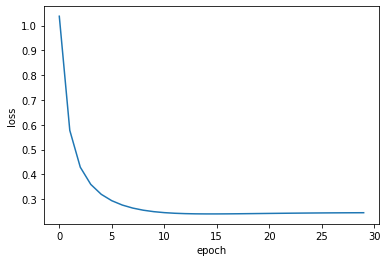

In [58]:
plt.xlabel("epoch")
plt.ylabel("loss")
plt.plot(nn1.train_loss_list)
plt.show()